
# Graph Neural Networks on Competition Data
<img style="float: right;" src="https://raw.githubusercontent.com/graphnet-team/graphnet/main/assets/identity/graphnet-logo-and-wordmark.png" width="600" height="600" />

Graph Neural Networks (GNNs) are a class of neural networks that work on graph representation of data. In recent years, development and application of GNNs have been of high interest in the machine learning community, and includes areas of research such as protein folding, computer vision and knowledge graphs. Part of the appeal of GNNs is the data representation itself - the graphs - as they provide an abstract and flexible format to represent a wide range of issues as GNN problems. Specifically for IceCube, GNNs are interesting because graphs allow us to naturally represent the irregular geometry. 

In a recent [publication from IceCube](https://iopscience.iop.org/article/10.1088/1748-0221/17/11/P11003), we show how a GNN compares against traditional methods on a series of reconstruction and classification tasks that are of common interest in neutrino physics in the low energy range of IceCube. While the paper explores applications in the low energy range, the GNN is applicable to higher energies too.

The GNN is called *dynedge* and is implemented in [GraphNeT](https://github.com/graphnet-team/graphnet). GraphNeT is an open-source python framework aimed at providing high quality, user friendly, end-to-end functionality to perform reconstruction tasks at neutrino telescopes using graph neural networks (GNNs). This [paper](https://arxiv.org/abs/2210.12194) (in review) supplements the details found in the github.

This notebook contains everything you need to tinker with GraphNeT on the competition data. It includes

1. Installation instructions for GraphNeT

2. Code for data conversion 

3. Snippets for training dynedge similarly to whats shown in the JINST paper

4. A pre-trained dynedge on batch 1 to 50.

5. Snippets for inference and evaluation of results.


We hope that this is enough to get you started with GNNs on the competition data. Once you've gotten the code running, you'll see that it doesn't require much to introduce a completely different GNN or to make changes to dynedge. Please feel free to tinker with all of the code - and if you want to - you're very much welcome to add your contributions via pull request on our github. This way, your work might benefit researchers across the globe! **But remember to read our [contribution guide](https://github.com/graphnet-team/graphnet/blob/main/CONTRIBUTING.md) first**!  

Finally, please note that the first stable release of GraphNeT is aimed for first half of 2023 - so you might still encounter bugs - and if you do, [please create an issue.](https://github.com/graphnet-team/graphnet/issues)




## Installing GraphNeT

You can find the official installation instructions for GraphNeT [here](https://github.com/graphnet-team/graphnet#gear--install) which contains guides for both CPU and GPU installation. However, I had to take a few extra steps to get the library installed in a Kaggle notebook. Run the cell below - it will copy a recent version of graphnet and it's dependencies to the working disk and install the GPU version of GraphNeT in /kaggle/working/software.

In [1]:
# Move software to working disk
!rm  -r software
!scp -r /kaggle/input/graphnet-and-dependencies/software .

# Install dependencies
!pip install /kaggle/working/software/dependencies/torch-1.11.0+cu115-cp37-cp37m-linux_x86_64.whl
!pip install /kaggle/working/software/dependencies/torch_cluster-1.6.0-cp37-cp37m-linux_x86_64.whl
!pip install /kaggle/working/software/dependencies/torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl
!pip install /kaggle/working/software/dependencies/torch_sparse-0.6.13-cp37-cp37m-linux_x86_64.whl
!pip install /kaggle/working/software/dependencies/torch_geometric-2.0.4.tar.gz

# Install GraphNeT
!cd software/graphnet;pip install --no-index --find-links="/kaggle/working/software/dependencies" -e .[torch]

# Append to PATH
import sys
sys.path.append('/kaggle/working/software/graphnet/src')

rm: cannot remove 'software': No such file or directory
Processing ./software/dependencies/torch-1.11.0+cu115-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
Processing ./software/dependencies/torch_cluster-1.6.0-cp37-cp37m-linux_x86_64.whl
Processing ./software/dependencies/torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl
Processing ./software/dependencies/torch_sparse-0.6.13-cp37-cp37m-linux_x86_64.whl
Processing ./software/dependencies/torch_geometric-2.0.4.tar.gz
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=1ab30289267a65bf6975b07d79aafecf38d24b4726a282a231fbe255073e9556
  Stored in directory: /root/.cache/pip/wheels/c0/33/a3/07aa146f758cd91ebee36268011873ae31c2cfc59dec089e04
Successfully built torch-geometric
Looking in links: /kaggle/working/software

In [2]:
import graphnet

## Converting The Parquet Files to SQLite

While GraphNeT have some support for parquet, the majority of functionality is tied to the SQLite data format. Therefore, to make GraphNeT compatible with the data provided in this competition, I've included a small converter that reads a selection of batch_id's and writes them to a single database. The database will contain two tables

* meta_table  : Contains the information associated with train_meta_data.parquet
* pulse_table : Contains the information associated with the batch_n.parquet files, including detector geometry.

both tables are indexed according to *event_id* for efficiency. This will allow you to extract information from the databases by simply writing

```python 
import pandas as pd
import sqlite3

my_event_id = 32
my_database = '/kaggle/working/sqlite/batch_01.db'

with sqlite3.connect(my_database) as conn:
    # extracts meta data for event
    meta_query = f'SELECT * FROM meta_table WHERE event_id ={my_event_id}'
    meta_data = pd.read_sql(meta_query,conn)
    
    # extracts pulses / detector response for event
    pulse_query = f'SELECT * FROM pulse_table WHERE event_id ={my_event_id}'
    pulse_data = pd.read_sql(query,conn)
```

The upside of the SQLite format is that you only have the events you want in memory. Downside is ... the conversion :-) 


In [3]:
import pyarrow.parquet as pq
import sqlite3
import pandas as pd
import sqlalchemy
from tqdm import tqdm
import os
from typing import Any, Dict, List, Optional
import numpy as np

from graphnet.data.sqlite.sqlite_utilities import create_table

def load_input(meta_batch: pd.DataFrame, input_data_folder: str) -> pd.DataFrame:
        """
        Will load the corresponding detector readings associated with the meta data batch.
        """
        batch_id = pd.unique(meta_batch['batch_id'])

        assert len(batch_id) == 1, "contains multiple batch_ids. Did you set the batch_size correctly?"
        
        detector_readings = pd.read_parquet(path = f'{input_data_folder}/batch_{batch_id[0]}.parquet')
        sensor_positions = geometry_table.loc[detector_readings['sensor_id'], ['x', 'y', 'z']]
        sensor_positions.index = detector_readings.index

        for column in sensor_positions.columns:
            if column not in detector_readings.columns:
                detector_readings[column] = sensor_positions[column]

        detector_readings['auxiliary'] = detector_readings['auxiliary'].replace({True: 1, False: 0})
        return detector_readings.reset_index()

def add_to_table(database_path: str,
                      df: pd.DataFrame,
                      table_name:  str,
                      is_primary_key: bool,
                      ) -> None:
    """Writes meta data to sqlite table. 

    Args:
        database_path (str): the path to the database file.
        df (pd.DataFrame): the dataframe that is being written to table.
        table_name (str, optional): The name of the meta table. Defaults to 'meta_table'.
        is_primary_key(bool): Must be True if each row of df corresponds to a unique event_id. Defaults to False.
    """
    try:
        create_table(   columns=  df.columns,
                        database_path = database_path, 
                        table_name = table_name,
                        integer_primary_key= is_primary_key,
                        index_column = 'event_id')
    except sqlite3.OperationalError as e:
        if 'already exists' in str(e):
            pass
        else:
            raise e
    engine = sqlalchemy.create_engine("sqlite:///" + database_path)
    df.to_sql(table_name, con=engine, index=False, if_exists="append", chunksize = 200000)
    engine.dispose()
    return

def convert_to_sqlite(meta_data_path: str,
                      database_path: str,
                      input_data_folder: str,
                      batch_size: int = 200000,
                      batch_ids: Optional[List[int]] = None,) -> None:
    """Converts a selection of the Competition's parquet files to a single sqlite database.

    Args:
        meta_data_path (str): Path to the meta data file.
        batch_size (int): the number of rows extracted from meta data file at a time. Keep low for memory efficiency.
        database_path (str): path to database. E.g. '/my_folder/data/my_new_database.db'
        input_data_folder (str): folder containing the parquet input files.
        batch_ids (List[int]): The batch_ids you want converted. Defaults to None (all batches will be converted)
    """
    if batch_ids is None:
        batch_ids = np.arange(1,661,1).to_list()
    else:
        assert isinstance(batch_ids,list), "Variable 'batch_ids' must be list."
    if not database_path.endswith('.db'):
        database_path = database_path+'.db'
    meta_data_iter = pq.ParquetFile(meta_data_path).iter_batches(batch_size = batch_size)
    batch_id = 1
    converted_batches = []
    progress_bar = tqdm(total = len(batch_ids))
    for meta_data_batch in meta_data_iter:
        if batch_id in batch_ids:
            meta_data_batch  = meta_data_batch.to_pandas()
            add_to_table(database_path = database_path,
                        df = meta_data_batch,
                        table_name='meta_table',
                        is_primary_key= True)
            pulses = load_input(meta_batch=meta_data_batch, input_data_folder= input_data_folder)
            del meta_data_batch # memory
            add_to_table(database_path = database_path,
                        df = pulses,
                        table_name='pulse_table',
                        is_primary_key= False)
            del pulses # memory
            progress_bar.update(1)
            converted_batches.append(batch_id)
        batch_id +=1
        if len(batch_ids) == len(converted_batches):
            break
    progress_bar.close()
    del meta_data_iter # memory
    print(f'Conversion Complete!. Database available at\n {database_path}')

graphnet: INFO     2023-04-17 18:25:09 - get_logger - Writing log to logs/graphnet_20230417-182509.log
graphnet: WARNING  2023-04-17 18:25:09 - warn_once - `icecube` not available. Some functionality may be missing.


/opt/conda/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


This notebook comes with both batch 1 and 51 converted to sqlite databases, so you don't have to convert them yourself. They were produced by running the following code:

```python 
input_data_folder = '/kaggle/input/icecube-neutrinos-in-deep-ice/train'
geometry_table = pd.read_csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')
meta_data_path = '/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet'

#batch_1
database_path = '/kagge/working/batch_1'
convert_to_sqlite(meta_data_path,
                  database_path=database_path,
                  input_data_folder=input_data_folder,
                  batch_ids = [1])

#batch_51
database_path = '/kagge/working/batch_51'
convert_to_sqlite(meta_data_path,
                  database_path=database_path,
                  input_data_folder=input_data_folder,
                  batch_ids = [51])
```

You can convert multiple batches into a single database by adjusting *batch_id*. Notice that the compression of SQLite is far inferiour to parquet. The entire competition dataset will take up more than 1.5T of disk space in SQLite.

Instead of producing these databases again, the next cell will copy them into /kaggle/working which is a faster disk.

In [4]:
# input_data_folder = '/kaggle/input/icecube-neutrinos-in-deep-ice/train'
# geometry_table = pd.read_csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')
# meta_data_path = '/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet'

# #batch_1
# database_path = '/kagge/working/batch_1'
# convert_to_sqlite(meta_data_path,
#                   database_path=database_path,
#                   input_data_folder=input_data_folder,
#                   batch_ids = [1])

# #batch_51 /kaggle/input/batch-1
# database_path = '/kagge/working/batch_51'
# convert_to_sqlite(meta_data_path,
#                   database_path=database_path,
#                   input_data_folder=input_data_folder,
#                   batch_ids = [51])

In [5]:
!cp /kaggle/input/batch-1/batch_1.db .
!cp /kaggle/input/batch-51/batch_51.db .

## Defining A Selection
The [SQLiteDataset class](https://github.com/graphnet-team/graphnet/blob/main/src/graphnet/data/sqlite/sqlite_dataset.py) is essentially a PyTorch Dataset (read more [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)) where the __get_item__ function extracts a single event at a time from the specified database. If a so-called *selection* is specified, only events in the selection are used for the dataset - that allows us to sub-sample the dataset for training.

In the following few cells, I'll introduce a simple selection based on the number of pulses. We'll then use this selection for training a GNN later.

In [6]:
from sklearn.model_selection import train_test_split
def make_selection(df: pd.DataFrame, pulse_threshold: int = 200) -> None:
    """Creates a validation and training selection (20 - 80). All events in both selections satisfies n_pulses <= 200 by default. """
    n_events = np.arange(0, len(df),1)
    train_selection, validate_selection = train_test_split(n_events, 
                                                                    shuffle=True, 
                                                                    random_state = 42, 
                                                                    test_size=0.20) 
    df['train'] = 0
    df['validate'] = 0
    
    df['train'][train_selection] = 1
    df['validate'][validate_selection] = 1
    
    assert len(train_selection) == sum(df['train'])
    assert len(validate_selection) == sum(df['validate'])

    #Remove events with large pulses from training and validation sample (memory)
    df['train'][df['n_pulses']> pulse_threshold] = 0
    df['validate'][df['n_pulses']> pulse_threshold] = 0
    
    for selection in ['train', 'validate']:
        df.loc[df[selection] == 1, :].to_csv(f'{selection}_selection_max_{pulse_threshold}_pulses.csv')
    return

def get_number_of_pulses(db: str, event_id: int, pulsemap: str) -> int:
    with sqlite3.connect(db) as con:
        query = f'select event_id from {pulsemap} where event_id = {event_id} limit 20000'
        data = con.execute(query).fetchall()
    return len(data)

def count_pulses(database: str, pulsemap: str) -> pd.DataFrame:
    """ Will count the number of pulses in each event and return a single dataframe that contains counts for each event_id."""
    with sqlite3.connect(database) as con:
        query = 'select event_id from meta_table'
        events = pd.read_sql(query,con)
    counts = {'event_id': [],
              'n_pulses': []}
    for event_id in tqdm(events['event_id']):
        a = get_number_of_pulses(database, event_id, pulsemap)
        counts['event_id'].append(event_id)
        counts['n_pulses'].append(a)
    df = pd.DataFrame(counts)
    df.to_csv('counts.csv')
    return df

The cell below will produce three csv files; training and validation selections, and a third files called *counts.csv*. 

In [7]:
pulsemap = 'pulse_table'
database = '/kaggle/working/batch_1.db'

df = count_pulses(database, pulsemap)
make_selection(df = df, pulse_threshold =  200)

100%|██████████| 200000/200000 [00:53<00:00, 3706.83it/s]


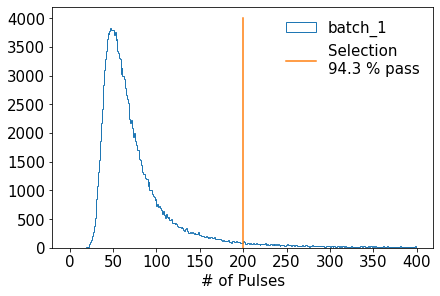

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
fig = plt.figure(figsize=(6,4), constrained_layout = True)
plt.hist(df['n_pulses'], histtype = 'step', label = 'batch_1', bins = np.arange(0,400,1))
plt.xlabel('# of Pulses', size = 15);
plt.xticks(size = 15);
plt.yticks(size = 15);
plt.plot(np.repeat(200,2), [0, 4000], label = f'Selection\n{np.round((sum(df["n_pulses"]<= 200)/len(df))*100, 1)} % pass' ) 
plt.legend(frameon = False, fontsize = 15);

In [9]:
print(f'Event with highest number of pulses counted: {df["n_pulses"].max()}')

Event with highest number of pulses counted: 20000


As visible from the plot, most events have less or equal to 200 pulses. The print message shows us that the outliers can have tens of thousands of pulses (20000 is the max we let it count in the code above). In principle, one could train the GNN without descrimination on this collection of events, but events with large pulse counts will make the memory usuage volatile and force a low batch size. Therefore (and feel free to challenge this) this notebook will train on events with 200 or less pulses.  

## Training DynEdge

Now that both database and selection is ready, everything is in place to begin training. DynEdge is a GNN implemented in GraphNeT - it represents IceCube events as 3D point clouds and leverages techniques from segmentation analysis in computer vision to reconstruct events. You can find technical details on the model in [this paper](https://iopscience.iop.org/article/10.1088/1748-0221/17/11/P11003). The model and training configuration shown below is nearly identical to what's presented in the paper. Note that this configuration was originally meant for low energy, so it's possible that some adjustments might improve performance.

In [10]:
from pytorch_lightning.callbacks import EarlyStopping
from torch.optim.adam import Adam
from graphnet.data.constants import FEATURES, TRUTH
from graphnet.models import StandardModel
from graphnet.models.detector.icecube import IceCubeKaggle
from graphnet.models.gnn import DynEdge
from graphnet.models.graph_builders import KNNGraphBuilder
from graphnet.models.task.reconstruction import DirectionReconstructionWithKappa, ZenithReconstructionWithKappa, AzimuthReconstructionWithKappa
from graphnet.training.callbacks import ProgressBar, PiecewiseLinearLR
from graphnet.training.loss_functions import VonMisesFisher3DLoss, VonMisesFisher2DLoss
from graphnet.training.labels import Direction
from graphnet.training.utils import make_dataloader
from graphnet.utilities.logging import get_logger
from pytorch_lightning import Trainer
import pandas as pd

logger = get_logger()

def build_model(config: Dict[str,Any], train_dataloader: Any) -> StandardModel:
    """Builds GNN from config"""
    # Building model
    detector = IceCubeKaggle(
        graph_builder=KNNGraphBuilder(nb_nearest_neighbours=8),
    )
    gnn = DynEdge(
        nb_inputs=detector.nb_outputs,
        global_pooling_schemes=["min", "max", "mean"],
    )

    if config["target"] == 'direction':
        task = DirectionReconstructionWithKappa(
            hidden_size=gnn.nb_outputs,
            target_labels=config["target"],
            loss_function=VonMisesFisher3DLoss(),
        )
        prediction_columns = [config["target"] + "_x", 
                              config["target"] + "_y", 
                              config["target"] + "_z", 
                              config["target"] + "_kappa" ]
        additional_attributes = ['zenith', 'azimuth', 'event_id']

    model = StandardModel(
        detector=detector,
        gnn=gnn,
        tasks=[task],
        optimizer_class=Adam,
        optimizer_kwargs={"lr": 1e-03, "eps": 1e-03},
        scheduler_class=PiecewiseLinearLR,
        scheduler_kwargs={
            "milestones": [
                0,
                len(train_dataloader) / 2,
                len(train_dataloader) * config["fit"]["max_epochs"],
            ],
            "factors": [1e-02, 1, 1e-02],
        },
        scheduler_config={
            "interval": "step",
        },
    )
    model.prediction_columns = prediction_columns
    model.additional_attributes = additional_attributes
    
    return model

def load_pretrained_model(config: Dict[str,Any], state_dict_path: str = '/kaggle/input/dynedge-pretrained/dynedge_pretrained_batch_1_to_50/state_dict.pth') -> StandardModel:
    train_dataloader, _ = make_dataloaders(config = config)
    model = build_model(config = config, 
                        train_dataloader = train_dataloader)
    #model._inference_trainer = Trainer(config['fit'])
    model.load_state_dict(state_dict_path)
    model.prediction_columns = [config["target"] + "_x", 
                              config["target"] + "_y", 
                              config["target"] + "_z", 
                              config["target"] + "_kappa" ]
    model.additional_attributes = ['zenith', 'azimuth', 'event_id']
    return model

def make_dataloaders(config: Dict[str, Any]) -> List[Any]:
    """Constructs training and validation dataloaders for training with early stopping."""
    train_dataloader = make_dataloader(db = config['path'],
                                            selection = pd.read_csv(config['train_selection'])[config['index_column']].ravel().tolist(),
                                            pulsemaps = config['pulsemap'],
                                            features = features,
                                            truth = truth,
                                            batch_size = config['batch_size'],
                                            num_workers = config['num_workers'],
                                            shuffle = True,
                                            labels = {'direction': Direction()},
                                            index_column = config['index_column'],
                                            truth_table = config['truth_table'],
                                            )
    
    validate_dataloader = make_dataloader(db = config['path'],
                                            selection = pd.read_csv(config['validate_selection'])[config['index_column']].ravel().tolist(),
                                            pulsemaps = config['pulsemap'],
                                            features = features,
                                            truth = truth,
                                            batch_size = config['batch_size'],
                                            num_workers = config['num_workers'],
                                            shuffle = False,
                                            labels = {'direction': Direction()},
                                            index_column = config['index_column'],
                                            truth_table = config['truth_table'],
                                          
                                            )
    return train_dataloader, validate_dataloader

def train_dynedge_from_scratch(config: Dict[str, Any]) -> StandardModel:
    """Builds and trains GNN according to config."""
    logger.info(f"features: {config['features']}")
    logger.info(f"truth: {config['truth']}")
    
    archive = os.path.join(config['base_dir'], "train_model_without_configs")
    run_name = f"dynedge_{config['target']}_{config['run_name_tag']}"

    train_dataloader, validate_dataloader = make_dataloaders(config = config)

    model = build_model(config, train_dataloader)

    # Training model
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=config["early_stopping_patience"],
        ),
        ProgressBar(),
    ]

    model.fit(
        train_dataloader,
        validate_dataloader,
        callbacks=callbacks,
        **config["fit"],
    )
    return model

def inference(model, config: Dict[str, Any]) -> pd.DataFrame:
    """Applies model to the database specified in config['inference_database_path'] and saves results to disk."""
    # Make Dataloader
    test_dataloader = make_dataloader(db = config['inference_database_path'],
                                            selection = None, # Entire database
                                            pulsemaps = config['pulsemap'],
                                            features = features,
                                            truth = truth,
                                            batch_size = config['batch_size'],
                                            num_workers = config['num_workers'],
                                            shuffle = False,
                                            labels = {'direction': Direction()},
                                            index_column = config['index_column'],
                                            truth_table = config['truth_table'],
                                            )
    
    # Get predictions
    results = model.predict_as_dataframe(
        gpus = [0],
        dataloader = test_dataloader,
        prediction_columns=model.prediction_columns,
        additional_attributes=model.additional_attributes,
    )
    # Save predictions and model to file
    archive = os.path.join(config['base_dir'], "train_model_without_configs")
    run_name = f"dynedge_{config['target']}_{config['run_name_tag']}"
    db_name = config['path'].split("/")[-1].split(".")[0]
    path = os.path.join(archive, db_name, run_name)
    logger.info(f"Writing results to {path}")
    os.makedirs(path, exist_ok=True)

    results.to_csv(f"{path}/results.csv")
    return results

In [11]:
# Constants
features = FEATURES.KAGGLE
truth = TRUTH.KAGGLE

# Configuration
config = {
        "path": '/kaggle/working/batch_1.db',
        "inference_database_path": '/kaggle/working/batch_51.db',
        "pulsemap": 'pulse_table',
        "truth_table": 'meta_table',
        "features": features,
        "truth": truth,
        "index_column": 'event_id',
        "run_name_tag": 'my_example',
        "batch_size": 200,
        "num_workers": 2,
        "target": 'direction',
        "early_stopping_patience": 5,
        "fit": {
                "max_epochs": 50,
                "gpus": [0],
                "distribution_strategy": None,
                },
        'train_selection': '/kaggle/working/train_selection_max_200_pulses.csv',
        'validate_selection': '/kaggle/working/validate_selection_max_200_pulses.csv',
        'test_selection': None,
        'base_dir': 'training'
}

In the cell below, you can choose between training dynedge from scratch on the batch_1 database or loading in a pretrained model that has trained on batches 1 to 50.

In [12]:
#Train from scratch (slow) - remember to save it!
model = train_dynedge_from_scratch(config = config)


# Load state-dict from pre-trained model (faster)
#model = load_pretrained_model(config = config)

graphnet: INFO     2023-04-17 18:26:51 - train_dynedge_from_scratch - features: ['x', 'y', 'z', 'time', 'charge', 'auxiliary']
graphnet: INFO     2023-04-17 18:26:51 - train_dynedge_from_scratch - truth: ['zenith', 'azimuth']


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [13]:
import torch

# Save the trained model to a file with .pth extension
torch.save(model.state_dict(), 'model_2.pth')


## Inference & Evaluation

With a trained model loaded into memory, we can now apply the model to batch_51. The following cells will start inference (or load in a csv with predictions, if you're in a hurry) and plot the results. 

In [14]:
# Inference
results = inference(model, config)

graphnet: WARNING  2023-04-17 19:39:50 - StandardModel.warning - A `Trainer` instance has already been constructed, possibly when the model was trained. Will use this to get predictions. Argument `gpus = [0]` will be ignored.


Predicting: 0it [00:00, ?it/s]

graphnet: INFO     2023-04-17 19:50:30 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [15]:
def convert_to_3d(df: pd.DataFrame) -> pd.DataFrame:
    """Converts zenith and azimuth to 3D direction vectors"""
    df['true_x'] = np.cos(df['azimuth']) * np.sin(df['zenith'])
    df['true_y'] = np.sin(df['azimuth'])*np.sin(df['zenith'])
    df['true_z'] = np.cos(df['zenith'])
    return df

def calculate_angular_error(df : pd.DataFrame) -> pd.DataFrame:
    """Calcualtes the opening angle (angular error) between true and reconstructed direction vectors"""
    df['angular_error'] = np.arccos(df['true_x']*df['direction_x'] + df['true_y']*df['direction_y'] + df['true_z']*df['direction_z'])
    return df

In [16]:
results = convert_to_3d(results)
results = calculate_angular_error(results)

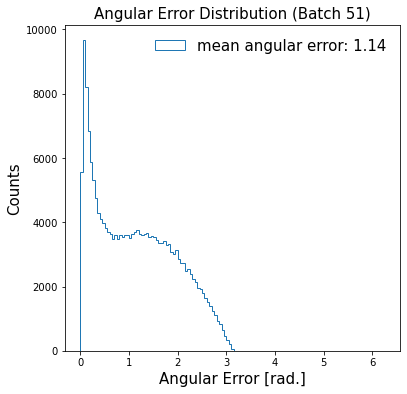

In [17]:
fig = plt.figure(figsize = (6,6))
plt.hist(results['angular_error'], 
         bins = np.arange(0,np.pi*2, 0.05), 
         histtype = 'step', 
         label = f'mean angular error: {np.round(results["angular_error"].mean(),2)}')
plt.xlabel('Angular Error [rad.]', size = 15)
plt.ylabel('Counts', size = 15)
plt.title('Angular Error Distribution (Batch 51)', size = 15)
plt.legend(frameon = False, fontsize = 15)

So the pre-trained dynedge seems to perform quite well. Another interesting feature of the reconstruction is that dynedge (when coupled with the[ DirectionReconstructionWithKappa](https://github.com/graphnet-team/graphnet/blob/7e857562898ebebebc9a105159fd3d4eb4994aea/src/graphnet/models/task/reconstruction.py#L45) is that dynedge estimated *kappa* the concentration parameter from the vonMisesFisher distribution. Kappa is analogus to sigma via sigma = 1/sqrt(kappa), and the quality of the direction estimate should be highly correlated with this parameter. 

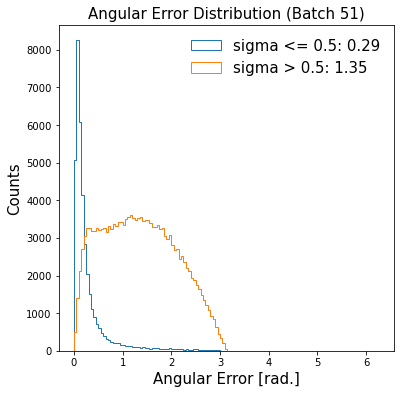

In [18]:
cut_threshold = 0.5
fig = plt.figure(figsize = (6,6))
plt.hist(results['angular_error'][1/np.sqrt(results['direction_kappa']) <= cut_threshold], 
         bins = np.arange(0,np.pi*2, 0.05), 
         histtype = 'step', 
         label = f'sigma <= {cut_threshold}: {np.round(results["angular_error"][1/np.sqrt(results["direction_kappa"]) <= cut_threshold].mean(),2)}')

plt.hist(results['angular_error'][1/np.sqrt(results['direction_kappa']) > cut_threshold], 
         bins = np.arange(0,np.pi*2, 0.05), 
         histtype = 'step', 
         label = f'sigma > {cut_threshold}: {np.round(results["angular_error"][1/np.sqrt(results["direction_kappa"]) > cut_threshold].mean(),2)}')
plt.xlabel('Angular Error [rad.]', size = 15)
plt.ylabel('Counts', size = 15)
plt.title('Angular Error Distribution (Batch 51)', size = 15)
plt.legend(frameon = False, fontsize = 15)

As you can see, the variable can be used to distinguish "good" and "bad" reconstructions with some confidence. 

## A few hints for your neutrino data science journey!

* The configuration of dynedge shown in this notebook is the so-called "baseline". It's not optimized for high energy neutrinos, so you might be able to squeeze out a bit more performance by tuning hyperparameters or making larger modifications; such as switching out the learning rate scheduler or choosing a different loss function, etc.

* You can use the kappa variable to group events into different categories. Perhaps training a seperate reconstruction method for each performs better?

* You may want to adjust the [ParquetDataset](https://github.com/graphnet-team/graphnet/blob/7e857562898ebebebc9a105159fd3d4eb4994aea/src/graphnet/data/parquet/parquet_dataset.py#L11) such that it works with the competition data. This would allow you to train / infer directly on the competition files (No conversion to sqlite needed). Feel free to contribute this to the repository!


Good luck!